# LIGO workshop: Data access and signal whitening 


In [12]:
# 
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import readligo as rl


File download complete
H-H1_LOSC_4_V1-1126076416-4096.hdf5


Text(0,0.5,'H1 Strain')

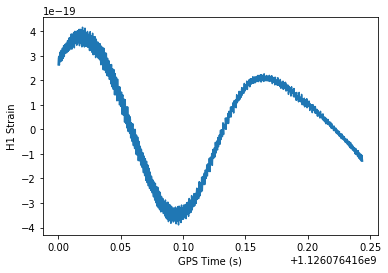

In [35]:
# Code to download data from url, (currently dont need as have already downloaded the data)

pyversion = sys.version_info.major
if pyversion == 2: 
    import urllib2
else:
    import urllib.request

# -- Handy function to download data file, and return the filename
def download(url):
    filename = url.split('/')[-1]
    print('Downloading ' + url )
    if pyversion == 2: 
        r = urllib2.urlopen(url).read()
        f = open(filename, 'w')   # write it to the right filename
        f.write(r)
        f.close()
    else:
        urllib.request.urlretrieve(url, filename)  
    print("File download complete")
    return filename

# -- Use the URL for a data file you found above
url = 'https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
#https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.hdf5
filename = url.split('/')[-1] # creates an array of the above string separated at the /'s, calls the final element 
download(url)
#url = 'https://losc.ligo.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
#filename = url.split('/')[-1] 

print(filename)
# -- Use the loaddata() method here to load strain data
strain, time, dq = rl.loaddata(filename, 'H1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')

Text(0,0.5,'H1 Strain')

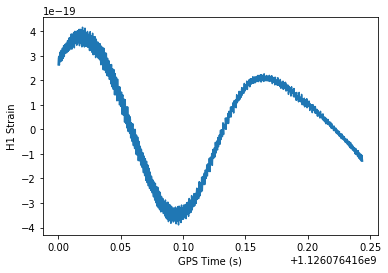

In [16]:
filename = url.split('/')[-1] 

# -- Use the loaddata() method here to load strain data
strain, time, dq = rl.loaddata(filename, 'H1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')



/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'Freq (Hz)')

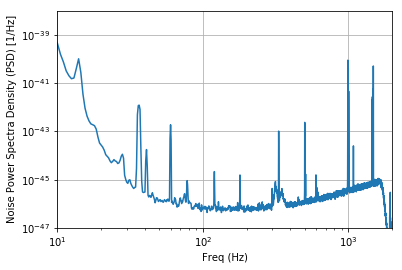

In [17]:
#-- Plot a PSD with 128 seconds of data 
ts = time[1] - time[0]      #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
length = 128                #-- Number of seconds

strain_seg = strain[0:(length*fs)]
time_seg = time[0:(length*fs)]

Pxx, freqs = mlab.psd(strain_seg, Fs=fs, NFFT=2*fs)
plt.loglog(freqs, Pxx)
plt.axis([10, 2000, 1e-47, 1e-38])
plt.grid('on')
plt.ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plt.xlabel('Freq (Hz)')

Check Questions
What are the strongest line features in the PSD above?
Hint: See notes on O1 spectral lines: https://losc.ligo.org/o1speclines/
What is the most sensitive frequency band for LIGO?
What is the ratio of noise power at 20 Hz compared with 100 Hz?
What are the main broad-band noise compentents at low-frequency (f<50 Hz) and high-frequency (f>300 Hz).

No handles with labels found to put in legend.
/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Text(0.5,1,'WHITENED strain')

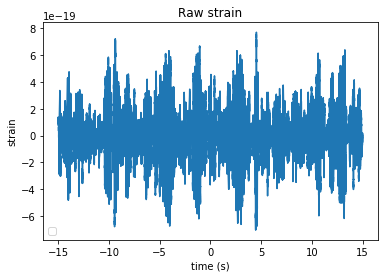

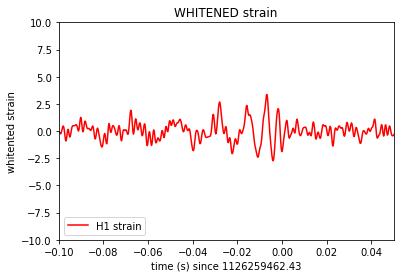

In [33]:
#Whitening 
#-- Download a data file containing GW150914 
url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
#fn_150914 = download(url)
fn_150914 = url.split('/')[-1] 


strain, time, chan_dict_H1 = rl.loaddata(fn_150914, 'H1')

# the time sample interval (uniformly sampled!)
t0 = 1126259462.43
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

#-- How much data to use for the ASD?
deltat = 15  # Number of seconds on each side of data
N_samp = deltat*fs

# -- Center the PSD segment on the requested time
indx = np.where(np.abs(rel_time) < dt)[0][0]
strain_seg = strain[indx-N_samp : indx+N_samp]
time_seg = rel_time[indx-N_samp : indx+N_samp]

fig2 = plt.figure()
plt.plot(time_seg,strain_seg) 


plt.xlabel('time (s) centered on ')
plt.ylabel('strain')
plt.legend(loc='lower left')
plt.title('Raw strain')

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000

# -- Calculate PSD
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT))

# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, Pxx)

# -- Whiten
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

# We need to suppress the high frequencies with some bandpassing:
high_freq = 600.
low_freq  = 30.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)

#-- Plot the whitened time series
fig3 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-0.1,0.05])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')

compare with livingston